https://pytorch.org/tutorials/beginner/nn_tutorial.html

https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification

https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

Batch RNN
https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html


![alt text](https://docs.gdc.cancer.gov/Encyclopedia/pages/images/barcode.png "TCGA Barcode")

To identify a sample, which is used for both methylation and expression measurements, we need only first 4 "-" separated identifiers, i.e. up to sample:vial level;

It is assumed that each patient is measured once (valid).



**TODO:**

- get gene sequence and coordinates (probably not worth representing as BioSeq, but check 0/1-base indexing issues)
- get cpgs coordinates
- combine and generate tensor

In [1]:
import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pybiomart import Dataset as BiomartDataset
# from torch.utils.tensorboard import SummaryWriter
# torch.manual_seed(42)


#print(torch.cuda.is_available())
#if torch.cuda.is_available() or True:
#    device = torch.device("cuda")          # a CUDA device object
#    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
#    x = x.to(device)                       # or just use strings ``.to("cuda")``
#    z = x + y
#    print(z)
#    print(z.to("cpu", torch.double)) 

In [2]:
import re
import json
import warnings

import numpy as np
from pathlib import Path
import pandas as pd

DIR = Path("/data/eugen/meth2expr/")
TCGA_DIR = Path("/data/eugen/tcga/projects")
GENOMICS_DIR = DIR / 'data/genomics/'
PROMS_PATH = DIR / "data/genomics/proms.fna"
METH_CHIP_PATH = DIR / "data/genomics/GPL13534-11288.txt"

projects = [str(x).split("/")[-1] for x in TCGA_DIR.iterdir() if x.is_dir()]
projects_paths = [x for x in TCGA_DIR.iterdir() if x.is_dir()]

cpgs_chip = pd.read_csv(METH_CHIP_PATH, sep='\t', header=37)
# cols = ['ID', 'Genome_Build', 'CHR', 'MAPINFO', 'Strand', "UCSC_RefGene_Name", 
#         "UCSC_RefGene_Accession", "UCSC_RefGene_Group", "UCSC_CpG_Islands_Name", "Relation_to_UCSC_CpG_Island",
#         'Enhancer', 'HMM_Island', 'Regulatory_Feature_Name', 'RANGE_START',
#         'RANGE_END', 'RANGE_GB']
cols = ['ID', 'RANGE_GB', 'MAPINFO', 'Strand']
cpgs_chip = cpgs_chip[cols]
cpgs_chip.head()

/data/miniconda3/envs/m2e/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (11,14,15,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,RANGE_GB,MAPINFO,Strand
0,cg00035864,NC_000024.9,8553009.0,F
1,cg00050873,NC_000024.9,9363356.0,R
2,cg00061679,NC_000024.9,25314171.0,R
3,cg00063477,NC_000024.9,22741795.0,F
4,cg00121626,NC_000024.9,21664296.0,R


In [3]:
PROJECTS_DIR = "/data/eugen/tcga/projects/"

class Project(object):
    """
    Project data loader and descriptor.
    
    :attributes:
    
    :public:
        get_case_data()
    
    :private:
        _collect_samples()
        _collect_metadata()
        _get_case_datapaths()
    """
    
    def __init__(self, name, projects_dir=PROJECTS_DIR):
        '''
        :params
            name -- project name
            path -- project dir
        '''
        self.name = name
        self.dir = projects_dir + name
        
        self.meth_path = None
        self.meth_fpath = None
        
        self.samples = {}
        self.sample_ids = []
        self.sample_paths = {}
        self.cases = {}
        self.case_ids = []
        self.meta = {}
        
        # Get samples ids and paths
        self._collect_samples()
        self._collect_metadata()
        
        
    def _collect_samples(self):
        """
        Extracts samples' ids and paths from project directory.
        """
        
        self.sample_paths = {"methylation": {},
                              "expression": {}}
        
        # Extract methylation
        self.meth_path = Path(self.dir) / 'data/methylation' / self.name / 'harmonized/DNA_Methylation/Methylation_Beta_Value'
        self.expr_path = Path(self.dir) / 'data/expression' / self.name / 'harmonized/Transcriptome_Profiling/Gene_Expression_Quantification'
        self.sample_paths = {datatype: {str(f).split("/")[-1]: str(f) 
                                        for f in path.iterdir()}
                             for datatype, path in [('methylation', self.meth_path), ('expression', self.expr_path)]}
        
        # In path there is an experiment ID, not sample id
        self.samples = {f: list(self.sample_paths[f].keys()) for f in ['methylation', 'expression']}
        self.sample_ids = list(self.samples.keys())
    
    
    def _collect_metadata(self):
        """
        Gets all necessary metadata of project.
        Includes ids and case ids: necessary to match expression and methylation measurements.
        """
        
        metadata_paths = [(Path(self.dir) / (self.name + "_" + f + ".csv"))
                              for f in ['methylation', 'expression'] ]
        
        ### Access metadata files
        cols = ['file_id', 'file_name', 'cases']
        meth, expr = list(map(lambda p: pd.read_csv(p, sep='\t', usecols=cols), metadata_paths))
        
        
        ### Prune the TCGA barcode of case ids up to sample level, resulting in Project-TSS-ParticipantID-<SampleID><vial>
        barcode_splitter = lambda x: "-".join(x.split('-')[:4])
        meth['cases'] = meth['cases'].apply(barcode_splitter)
        expr['cases'] = expr['cases'].apply(barcode_splitter)

                          
        meth = meth.set_index("file_id", drop=False)
        expr = expr.set_index("file_id", drop=False)
        
        meta = {'methylation': meth.to_dict(orient='index'),
                'expression': expr.to_dict(orient='index') }
        
        # Assert equivalency of ids in metadata files and available files
        assert set(meta['methylation'].keys()) == set(self.samples['methylation'])
        assert set(meta['expression'].keys()) == set(self.samples['expression'])
        
        self.meta = meta
        
        
        ### Collect metadata for cases
        
        # There may be case duplicates, will drop
        meth_dup = meth['cases'][meth.duplicated(['cases'], keep=False)]
        expr_dup = expr['cases'][expr.duplicated(['cases'], keep=False)]
        dup = set(meth_dup).union(set(expr_dup))  # set of duplicated cases in meth or expr
        if (len(dup) > 0):
            warnings.warn("Droping duplicated cases entries.", UserWarning)
        meth = meth.loc[~(meth['cases'].isin(dup))]
        expr = expr.loc[~(expr['cases'].isin(dup))]
        
        meth = meth.set_index("cases")
        expr = expr.set_index("cases")
        
        # recheck equivalency of cases for methylation and expression (should be true by constraint of download script)
        if (set(meth.index) != set(expr.index)):
            warnings.warn("There is non-equivalence of cases in methylation and expression. To check.")
            common_cases = set(meth.index).intersection(set(expr.index))
            meth = meth.loc[common_cases]
            expr = expr.loc[common_cases]
            
        
        cases = {'methylation': meth.to_dict(orient='index'),
                 'expression': expr.to_dict(orient='index') }
        self.old_cases = cases
        
        
            
            
        # make cases as keys { case -> {methylation -> {}; expression  -> {}} }
        new_dict = {case: {'methylation': cases['methylation'][case],
                           'expression': cases['expression'][case]}
                    for case in cases['methylation'].keys() }
        
        self.cases = new_dict
        self.case_ids = list(self.cases.keys())
        
        
    def _get_case_datapaths(self, case: str):
        '''Getter method for meth, expr or both types data.'''
        
        assert case in self.cases.keys()
        
        self.meth_fpath = Path(self.meth_path) / self.cases[case]['methylation']['file_id'] / self.cases[case]['methylation']['file_name']
        self.expr_fpath = Path(self.expr_path) / self.cases[case]['expression']['file_id'] / self.cases[case]['expression']['file_name']
        
        return {'methylation': self.meth_fpath, 'expression': self.expr_fpath}
    
    
    def get_case_data(self, case: str, genes = None, cpgs = None, get_expr=True, get_meth=True) -> dict:
        """
        Get case methylation and expression dataframe.
        
        :params
            case -- case id;
            genes -- list of genes to get data for. if None: gets data for all genes;
            cpgs -- list of cpgs to get data for. if None: gets data for all cpgs;
        """
        
#         get_expr, get_meth = True, True
        paths = self._get_case_datapaths(case)
        
        # We ignore rest columns, since terribly redundant. They describe CpG features, which are assumed to be constant for every
        # experiment (to be tested). That's the reason for the inefficient data storage. After testing invariance,
        # methylation data files have to cleared (i.e. remove redundant columns).
        meth_cols = ['Beta_value']  # 'Composite Element REF' becomes index
        
        # load both meth and expr for now
        # if dtype == 'methylation':
        #     get_expr = False
        # elif dtype == 'expression':
        #     get_meth = False
        
        if get_expr:
            if genes is not None:
                expr = pd.read_csv(paths['expression'], sep='\t', index_col=0, header=None)
                expr.index = list(map(lambda x: x.split(".")[0], expr.index))  # cut off version of ids e.g. ENS0000.1 -> ENS0000
                expr = expr.loc[genes]
            else:
                expr = pd.read_csv(paths['expression'], sep='\t', index_col=0, header=None)
        else:
            expr = None
        
        if get_meth:
            if cpgs is not None:
                meth = pd.read_csv(paths['methylation'], sep='\t', index_col=0, header=0)[meth_cols].loc[cpgs]
            else:
                meth = pd.read_csv(paths['methylation'], sep='\t', index_col=0, header=0)[meth_cols]
        else:
            meth = None
        
        return {'methylation': meth, 'expression': expr}

In [4]:
VOCAB = ['A', 'C', 'T', 'G', 'N']
BASE2IDX = {"A": 0, "C": 1, "T": 2, "G": 3, "N": 4}

def base2tensor(base: str, vocab: list = VOCAB) -> torch.tensor:
    tensor = torch.zeros(1, len(vocab))
    tensor[BASE2IDX[base]][0] = 1
    return tensor
    
def seq2tensor(seq: str, vocab: list = VOCAB) -> torch.tensor:
    tensor = torch.zeros(len(seq), 1, len(vocab))  # important choice for preserving shape compatibility with hidden layer.
    for idx, base in enumerate(seq):
        tensor[idx][0][BASE2IDX[base]] = 1  # that extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.
    return tensor

# def methylate_seq(seq_tensor: torch.tensor, loc: int, value: float, meth_idx: int, mask_idx: int) -> torch.tensor:
#     # only C or N can be methylated
#     assert (seq_tensor[loc][0][meth_idx] > 0) or (seq_tensor[loc][0][mask_idx] > 0)
#     seq_tensor[loc][0][meth_idx] = value
#     return seq_tensor

In [267]:
from pyfaidx import Fasta  # random access to fasta

# List of columns with info may use later, for now ignore;
# cols = ['ID', 'Genome_Build', 'CHR', 'MAPINFO', 'Strand', "UCSC_RefGene_Name", 
#         "UCSC_RefGene_Accession", "UCSC_RefGene_Group", "UCSC_CpG_Islands_Name", "Relation_to_UCSC_CpG_Island",
#         'Enhancer', 'HMM_Island', 'Regulatory_Feature_Name', 'RANGE_START',
#         'RANGE_END', 'RANGE_GB']
with open(GENOMICS_DIR / 'genes.json', 'r') as f:
    genes_dict = json.load(f)
cols = ['ID', 'RANGE_GB', 'MAPINFO', 'Strand']  # essential info for finding location
cpgs_chip = pd.read_csv(METH_CHIP_PATH, sep='\t', header=37, usecols=cols)


class Gene(object):
    """
    .
    """
    
    def __init__(self, name, genomics_dir=GENOMICS_DIR):
        """
        TODO: think about how to compute for each gene local coordinates for CpGs within promoter.
        """
        self.dir = genomics_dir
        self.name = name
        self.features = {}
        self.gene_cpgs = None
        self.promoter_seq = None
        self.tensor = None
        self.mask_idx = BASE2IDX["N"]
        self.meth_idx = BASE2IDX["C"]
        
        
        with open(GENOMICS_DIR / 'genes.json', 'r') as f:
            self.features = json.load(f)[self.name]
        
        self._get_promoter_seq()
        self._get_cpgs()
        self._tensorize()
        
        
    def __str__(self):
        return self.name
    
    
    def __repr__(self):
        return self.tensor
    
    
    def _get_promoter_seq(self, fpath = PROMS_PATH):
        """
        Load the promoter sequence.
        TODO: remove duplicates from fasta. Just rerun 01_, modified code.
        """
        prom = Fasta(str(PROMS_PATH))[self.name + "(" + self.features['strand'] + ")"]
        self.promoter_seq = str(prom).upper()
        return self.promoter_seq
    
    
    def _get_cpgs(self, cpg_df = cpgs_chip):
        """
        Load the gene's cpgs.
        """
        
        if self.features['strand'] == '+':
            strand = 'F'
        elif self.features['strand'] == '-':
            strand = 'R'
        else:
            raise ValueError
            
        df = cpg_df[(cpg_df['RANGE_GB'] == self.features['chr']) 
                    & (cpg_df['Strand'] == strand)
                    & (cpg_df['MAPINFO'] >= int(self.features['start'])) 
                    & (cpg_df['MAPINFO'] <= int(self.features['end']))]
        
        df = df.set_index('ID', drop=False)
        
        self.gene_cpgs = df.to_dict(orient='index')
        
        return self.gene_cpgs
    
    
    def _tensorize(self):
        """
        Represent sequence as tensor.
        """
        self.tensor = seq2tensor(self.promoter_seq)
    
    
    def methylate_tensor(self, cpgs=None):
        """
        Methylate the tensor with values.
        """
#         raise NotImplementedError
        
        assert self.tensor is not None
        
        if cpgs is None:
            if self.gene_cpgs is None:
                cpgs = self._get_cpgs()
            else:
                cpgs = self.gene_cpgs
        
        for cpg in cpgs:
            # insert cpg value in row for meth_base (cytosine)
            cpg_loc = cpg[0]
            cpg_value = cpg[1]
            seq = methylate_seq(self.tensor, cpg_loc, cpg_value, self.meth_idx, self.mask_idx)
                    
        self.tensor = seq
        return seq

In [268]:
g = Gene("7133")
print(g.promoter_seq, g.features)
cpgs = g._get_cpgs()
cpgs

ACATTCTCTCCCAGCCTCTGTTCATCTGCCCCCTGCCTGGGCAGGAGACTTGAGCAGGGAAGTGCAGAGTCTTCTCCCTGTGAGAAGGCTGGATGCGTGTTTAAGGATAAATGAACACGCGAAGAGTAGTAACAACAGCCAAGATTTATAAATGCCTATTGTTATATATGTAGATACTTACTTAAGTATATATAAAGTACAGACTGCATTATGTATATTACATATCTTTAAATTTTTAGAATAGTCCTATGAGGTCAGTTCAGAGATCCAGACCCAGGTGGTCTGGCTCTAGAGTCTAAACAGGCCGAGTGCAGTGGCTCACACCTATAATCCCAGCACCTTGGGAGGCCAGAGGCGGGAAGATCACTTGAGGGTGGGAAGAACACGTGAGCTCAGGAGTTCGAGACCAGCCTGGACAACATGGCGAAACCCCATCTCTATAAAGAAATCAGCCTAGCATGGTGGCCCGAGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGGTGGGAGGATCGCTTGAGCGCAGGAGTTGGAGGCTGCAGTGAGCTATGGGTGAAAGAGTGAGACCTTGTCTCAAAAAAAATTAAAAAATAAGAATTAAATATATTTAAAATAGAGTCTAAATAAGTGAATGATCTAGAATTCTCTTGGTTCCCCTAAAGCAGCTGTCAGCTTTGGGGGATGTTTTTCCAAATTAGTGCCTCACCCTCACGGGACAGGGAAGCCTGTGGGAGCTGGGAGGGCAGGTGGAGGCCGGGCAGGTGGAGGCCGGGCAGGTGGAGATGGTGATTCGAAGAGGAGGGGACGATAGGAGGAGGTTGAGGGGTCACCCGAGTGCTGGGAGTGACGCTGGAGGTATCGGCCCAGCGATGCTGGAGTGGTCGGGTCGGAGGCCCAGCAGCGTCTGGGGAGGGGCGTGGGGGAGGCGTGTCCAAGGCCGGCTGGCCCCGCCCCGCCCCGCCGCCTGGCCTCTGGCCCGCTGGGGCGCGGGCTTTCGCTTTC

{'cg09818691': {'ID': 'cg09818691',
  'MAPINFO': 12226143.0,
  'Strand': 'F',
  'RANGE_GB': 'NC_000001.10'}}

In [269]:
idx = int(cpgs['cg09818691']['MAPINFO']) - int(g.features['start'])
g.promoter_seq[idx-5:idx+3]

'GGATGCGT'

In [270]:
# '''
# Key data loading functionality should be implemented in a dataset object and look like this:

# get_data(projects: list, genes: list):
#     return (seq, cpgs, expr)
    
# Regarding data flow:
# 1) Create all CpG objects from Illumina file
# 2) Create all gene objects (here define cpg appartenence to gene)
# '''


# class Cpg(object):
#     """
#     .
#     """
    
#     def __init__(self, name):
#         """
#         .
#         """
#         self.name = name
#         self.start = None
#         self.end = None
#         self.strand = None
#         self.genes = []

        
# class PromoterDataset(Dataset):
#     """
#     Model an immutable container for dataset.
#     """
    
#     def __init__(self, projects: list, genes: list):
#         '''Initializes dataset with given projects and genes.'''
        
#         self.projects = []
#         for proj_name in projects:
#             # Add each project as Project object, which points to all relevant files for loading records
#             # in __get__item
#             self.projects.append(Project(proj_name))
        
#         self.genes = []
    
#     def __len__(self):
#         return len(self.projects) * len(self.genes)
    
#     def __getitem__(self):
#         return 0

In [271]:
# import unittest

# class TestProject(unittest.TestCase):
#     """."""
    
#     self.case = 'TCGA-2G-AAHC-01A'
#     self.genes = ['ENSG00000242268.2', "ENSG00000167578.15", "ENSG00000105063.17"]
#     self.cpgs = ['cg00000029', 'cg00000165', 'rs966367', 'rs9363764']
    
#     def test_get_case_data(self):
#         raise NotImplementedError

Main interface

In [272]:
proj = 'TCGA-TGCT'
proj_path = '/data/eugen/tcga/projects/'

P = Project(proj, proj_path)

case = 'TCGA-2G-AAHC-01A'
genes = ['ENSG00000242268', "ENSG00000167578", "ENSG00000105063"]
cpgs = ['cg00000029', 'cg00000165', 'rs966367', 'rs9363764']

case_data = P.get_case_data(case, genes, cpgs)
expr = case_data['expression']
meth = case_data['methylation']

In [273]:
# P.cases

In [274]:
# Project('TCGA-LGG', '/data/eugen/tcga/projects/').cases

In [275]:
# import pandas as pd
#p = Path("/data/eugen/tcga/projects") / proj
#[f for f in p.iterdir()]
# meth = pd.read_csv(Path("/data/eugen/tcga/projects") / proj /"TCGA-TGCT_methylation.csv", sep='\t')
# expr = pd.read_csv(Path("/data/eugen/tcga/projects") / proj /"TCGA-TGCT_expression.csv", sep='\t')

In [276]:
#meth = meth.set_index("file_id")
#meth = meth.to_dict(orient='index')
# meth.set_index('cases', drop=False)

In [277]:
# cols = ['file_id', 'file_name', 'cases']
# expr[cols].head()

In [278]:
P = Project('TCGA-TGCT', "/data/eugen/tcga/projects/")
# P.samples['expression']
# "f95eb680-d99e-4145-b2dd-651311f38acc" in P.samples['expression']

In [279]:
# VOCAB = ['A', 'C', 'T', 'G', 'N']
# BASE2IDX = {"A": 0, "C": 1, "T": 2, "G": 3, "N": 4}


# def findall(base: str, seq: str):
#     idxs = []
#     for m in re.finditer(base, seq):
#         idxs.append(m.start(0))
#     return idxs


# def random_seq(l: int, vocab: list = VOCAB) -> str:
#     return "".join(np.random.choice(vocab, l))


# def random_data(m: int, l: int, c: int) -> tuple:
#     """
#     Generates random dataset consisting of m sequences of length l with up to c cpg sites per sequence.
#     """
#     assert c < l

#     seqs = [random_seq(l, ) for _ in range(m)]
#     cpgs = [[(np.random.choice(findall("C", seqs[i])), np.random.random()) for _ in range(np.random.randint(0, c))] for i in range(m)]
#     exprs = [float(np.random.binomial(n=1, p=x.count('N')/len(x), size=1)[0]) for x in seqs]

#     return seqs, cpgs, exprs


# def base2tensor(base: str, vocab: list = VOCAB) -> torch.tensor:
#     tensor = torch.zeros(1, len(vocab))
#     tensor[BASE2IDX[base]][0] = 1
#     return tensor


# def seq2tensor(seq: str, vocab: list = VOCAB) -> torch.tensor:
#     tensor = torch.zeros(len(seq), 1, len(vocab))  # important choice for preserving shape compatibility with hidden layer.
#     for idx, base in enumerate(seq):
#         tensor[idx][0][BASE2IDX[base]] = 1  # that extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.
#     return tensor


# def methylate_seq(seq_tensor: torch.tensor, loc: int, value: float, meth_idx: int, mask_idx: int) -> torch.tensor:
#     assert (seq_tensor[loc][0][meth_idx] > 0) or (seq_tensor[loc][0][mask_idx] > 0)# assert it is a "C" in first place
#     seq_tensor[loc][0][meth_idx] = value
#     return seq_tensor


# class PromoterArtificialDataset(Dataset):
#     """
#     Dataset class for loading data. Communicates with loader object to bring batched data.
    
#     @attributes
#     @methods
    
#     Example:
#     ...
#     """

#     def __init__(self, data: tuple):
        
#         self.seqs, self.cpgs, self.exprs = data
        
#         # get some utile attributes
#         self.vocab = sorted(set("".join(self.seqs)))  # returns list
#         self.vocab_size = len(self.vocab)
#         self.base_to_idx = {}
#         for i, base in enumerate(VOCAB):
#             self.base_to_idx[base] = i
        
#         self.meth_base = "C"  #set methylated base
#         self.mask_base = "N"
#         self.meth_idx = self.base_to_idx[self.meth_base]
#         self.mask_idx = self.base_to_idx[self.mask_base]
        
        
#     def __len__(self):
#         return len(self.exprs)


#     def __getitem__(self, idx):
#         """Getter."""
#         seq = seq2tensor(self.seqs[idx])
#         cpgs = self.cpgs[idx]
#         expr = self.exprs[idx]

#         for cpg in cpgs:
#             # insert cpg value in row for meth_base (cytosine)
#             cpg_loc = cpg[0]
#             cpg_value = cpg[1]
#             seq = methylate_seq(seq, cpg_loc, cpg_value, self.meth_idx, self.mask_idx)

#         return seq, expr
            

# m = 100
# l = 50
# c = 5
# VOCAB = ['A', 'C', 'T', 'G', 'N']
# BASE2IDX = {"A": 0, "C": 1, "T": 2, "G": 3, "N": 4}
# data = random_data(m, l, c)

# # test_loader, train_loader
# train_set = PromoterArtificialDataset(data)
# train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)

In [280]:
def download_lookup(path='../data/genomics/gene_id_lookup.csv'):
    
    dataset = BiomartDataset(name='hsapiens_gene_ensembl',
                             host='http://www.ensembl.org')
    
    # attrs = dataset.list_attributes()
    # attrs[list(map(lambda x: bool(re.search(r'entrez', x)), attrs['name']))]
    
    lk = dataset.query(attributes=['ensembl_gene_id', 'entrezgene_id'],
                       filters=None).dropna()
    lk['NCBI gene ID'] = lk['NCBI gene ID'].astype('int32')
    lk.to_csv(path, index=False, header=True)
    
    return lk


def converter(genes, to: str, lk_path='../data/genomics/gene_id_lookup.csv'):
    '''Convert Ensembl to NCBI ids.'''
    
    assert to in ['ENS', 'ENTREZ']
    
    path = Path(lk_path)
    
    if not path.is_file():
        lk = download_lookup()
    else:
        lk = pd.read_csv(path)  # lookup table
    
    lk["NCBI gene ID"] = lk["NCBI gene ID"].astype("int32")
#     lk['Gene stable ID'] = list(map(lambda x: x.split(".")[0], 'Gene stable ID'))
    
    if to == 'ENTREZ':
        id_col = "Gene stable ID"
        conv_col = "NCBI gene ID"
    else:
        id_col = "NCBI gene ID"
        conv_col = "Gene stable ID"
        genes = list(map(int, genes))
    
    assert set(genes).issubset(set(lk[id_col]))
    ids = lk.set_index(id_col).loc[genes][conv_col].to_list()
    
    return ids

In [293]:
class MethExprDataset(Dataset):
    '''
    .
    '''
    
    def __init__(self, genes: list, projects: list, cases = list):
        '''.'''
                
        self.data = {}
        
        
        # Lookup table, genes in fasta
        with open("../data/genomics/genes.json", 'r') as f:
            available_genes = json.load(f)  # Entrez
        lk = download_lookup()
        lk = lk.loc[lk['NCBI gene ID'].isin(available_genes.keys())]
        
        
        if genes[0][:3] == 'ENS':
            gene_entrez_ids = converter(genes, to='ENTREZ')
            gene_ensembl_ids = genes
        else:
            gene_entrez_ids = genes
            gene_ensembl_ids = converter(genes, to='ENS')
        
        
        record_id = 0
        for proj in projects:
            p = Project(proj)
            
            for case in cases:    
                if case not in p.cases.keys():
                    continue
                    
                expr = p.get_case_data(case, gene_ensembl_ids, get_meth=None)['expression']
                expr = pd.merge(expr, lk, left_index=True, 
                                right_on='Gene stable ID', how='inner')
                expr.set_index("NCBI gene ID", drop=False, inplace=True)
                
                case_cpgs = p.get_case_data(case, cpgs=None, get_expr=False)['methylation']

                # idx = int(cpgs['cg09818691']['MAPINFO']) - int(g.features['start'])
                
                assert len(set(expr.index)) == len(set(genes))
                
                for gene in expr.index:
                    
                    # Get all gene data
                    g = Gene(str(gene))  # add window parameters
                    gene_cpgs = g._get_cpgs()
                    
                    cpgs = []
                    for cpg, d in gene_cpgs.items():
                        loc = int(d['MAPINFO'] - int(g.features['start']))
                        value = case_cpgs.loc[cpg].values[0]
                        print(loc, value)
                        cpgs.append((loc, value))
                        
                    g.methylate_tensor(cpgs=cpgs)
                    
                    self.data[record_id] = (g.tensor, expr.loc[[gene]])
                    record_id += 1
        pass
    
    
    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        return self.data[idx]
    
    
    def save(self):
        raise NotImplementedError
    
    
    def load(self, fp):
        raise NotImplementedError

In [297]:
def methylate_seq(seq_tensor: torch.tensor, loc: int, value: float, meth_idx: int, mask_idx: int) -> torch.tensor:
    # only C or N can be methylated
#     assert (seq_tensor[loc][0][meth_idx] > 0) or (seq_tensor[loc][0][mask_idx] > 0)
    seq_tensor[loc][0][meth_idx] = value
    return seq_tensor

In [298]:
genes = ["11215", "91582", "285335"]
cases = ['TCGA-2G-AAHC-01A', 'TCGA-4K-AA1G-01A', 'TCGA-GM-A2DA-01A', 'TCGA-DU-6400-01A', 'TCGA-TQ-A7RI-01A']
projects = ['TCGA-TGCT', 'TCGA-BRCA', 'TCGA-LGG']

In [429]:
ds = MethExprDataset(genes, projects, cases)

/data/miniconda3/envs/m2e/lib/python3.7/site-packages/ipykernel_launcher.py:172: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


334 0.172476401333216
148 0.053682320637039996
232 0.0347892843524738
582 0.7819782659658859
582 0.7819782659658859
334 0.0585524464328272
148 0.0384480548994658
232 0.131081927298501
582 0.43489196401328495
582 0.43489196401328495


/data/miniconda3/envs/m2e/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Droping duplicated cases entries.
/data/miniconda3/envs/m2e/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: There is non-equivalence of cases in methylation and expression. To check.


334 0.12013906402613199
148 0.112750583338484
232 0.0501462379736237
582 0.758942421091462
582 0.758942421091462
334 0.0295707528407641
148 0.0397351241265033
232 0.0446677629161387
582 0.871783738452435
582 0.871783738452435
334 0.0333175973005171
148 0.0337712695157636
232 0.043411349504558994
582 0.648258390367245
582 0.648258390367245


In [432]:
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian


def build_gaussian_filter(N=N, sd=SD):
    gaussian_window = gaussian(N, SD)
    plt.stem(gaussian_window, use_line_collection=True)
    return gaussian_window


def cytosine_signals(ds) -> list:
    sigs = []
    for idx, d in ds.data.items():
        Cs = d[0][:, 0, 1].numpy().copy()
        Cs[Cs == 1] = 0
        sigs.append(Cs)
    plt.stem(sigs[0], use_line_collection=True)
    plt.show()
    return sigs


def stemplots(sigs, gaussian_window):
    
    assert len(sigs) <= 10
    fig, axs = plt.subplots(nrows=len(sigs), ncols=2, figsize=(15,20))
    
    for i, ax in enumerate(axs):
        
        ax[0].stem(sigs[i], use_line_collection=True)
        
        conv = np.convolve(sigs[i], gaussian_window)
        warnings.warn("Make the filter symmetric.", UserWarning)
        ax[1].stem(conv, use_line_collection=True)

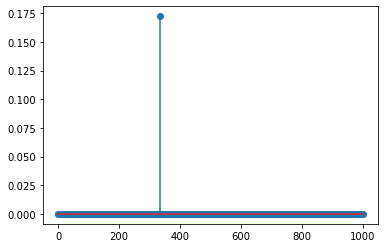

/data/miniconda3/envs/m2e/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Make the filter symmetric.


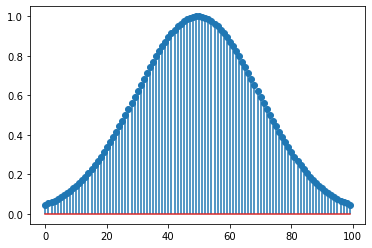

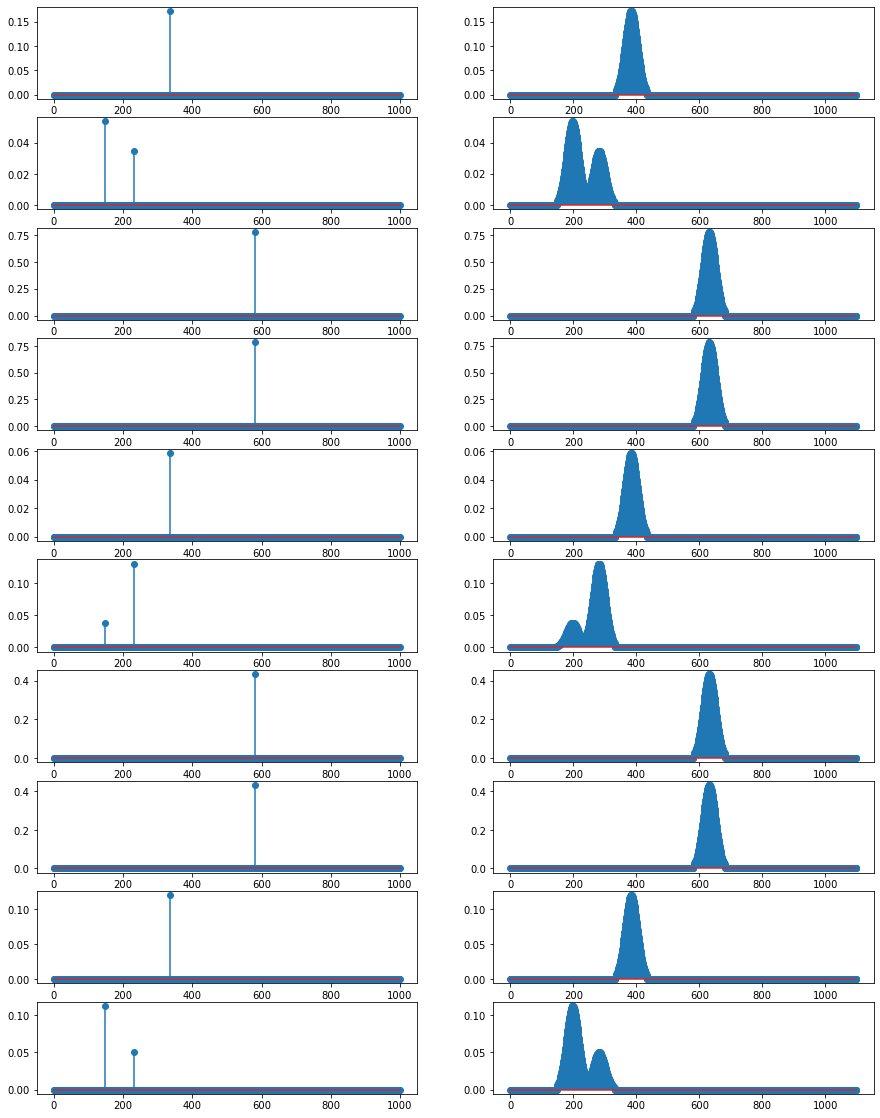

In [433]:
sigs = cytosine_signals(ds)
gauss = build_gaussian_filter(N=100, sd=20)
stemplots(sigs[:10], gauss)